# Estimation of factor risk premia

This section of the study was not included in the online appendix or in the replication code / data. 

Galvao et al discussed estimating factor risk premia under time-varying beta loadings, unobserved factors, and cross-correlation. 

The authors propose a test statistic and justify its asymptotic properties both theoretically and through a MC study. 

The estimation of factor risk premia requires solving a constrained non-convex optimization problem, to which the authors propose a iterative approach. 

In this notebook, we attempt to solve the same optimization problem using 1) a penalty-based unconstrained optimization approach and 2) the iterative approach.


## Notebook Setup

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys 
sys.path.append('../')
from utils import utils
from utils.utils import iterative_convergence, penalty_based_minimization
sys.executable

'/Users/fanghema/Desktop/aaSTAT_5200/STAT_5200_final_project/env/bin/python'

In [2]:
data = pd.read_csv(
    '../data/processed/data_galvao.csv',
    index_col=0,
    parse_dates=True
)

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
assets = [col for col in data.columns if col != 'RF' and col not in factors]

def calculate_factor_loading(
    input_df: pd.DataFrame,
    factors: list[str],
    assets: list[str],
) -> tuple[pd.DataFrame, pd.DataFrame]: 
    """
    Given DataFrame of (non-excess) asset returns 
    and factor returns, 
    returns panel data of factor loadings

    Args:
        input_df (pd.DataFrame): DataFrame indexed on date,
            with column names corresponding to assets
        factors (list[str]): list of factors
        assets (list[str]): list of risky assets

    Returns:
        pd.DataFrame: panel data of factor loadings
        pd.DataFrame: modified returns dataframe with excess returns
    """

    assert type(input_df.index) == pd.DatetimeIndex, "input_df has wrong index"
    for factor in factors:
        assert factor in input_df.columns, f"missing factor {factor}"
    for asset in assets:
        assert asset in input_df.columns, f"missing asset {asset}"
    assert "RF" in input_df.columns, f"Missing risk free"
    
    input_df.sort_index(inplace=True)
    N = len(assets)
    K = len(factors)
    input_df['Quarter'] = input_df.index.to_period("Q")
    T = input_df['Quarter'].nunique()

    for col in assets:
        input_df[col] = input_df[col] - input_df["RF"]
    
    cols = list(assets) + list(factors)

    realized_covariance_matrices = np.zeros((N, K, T))

    quarters = sorted(input_df['Quarter'].unique())
    for i, quarter in enumerate(quarters):
        returns = (
            input_df.loc[
                input_df['Quarter'] == quarter,
                cols
            ]
            .values
        )
        Omega_hat_t = returns.T @ returns
        realized_covariance_matrices[:, :, i] = Omega_hat_t[:N, N:N+K]
    
    beta_loading = pd.DataFrame(
        index = pd.MultiIndex.from_product([assets, factors]),
        columns = input_df['Quarter'].unique(),
    )

    for i, asset in enumerate(assets):
        for j, factor in enumerate(factors):
            omega_i_j_series = realized_covariance_matrices[i, j, :]
            Y = omega_i_j_series[1:]
            X = (
                np.column_stack([
                    np.ones(len(Y)),
                    omega_i_j_series[:-1]
                ])
            )
            b = np.linalg.lstsq(X, Y, rcond=None)[0]
            delta0, delta1 = b
            beta_loading.loc[(asset, factor)] = delta0 + delta1 * omega_i_j_series

    return beta_loading, input_df

beta_loading, returns_df = calculate_factor_loading(data, factors=factors, assets=assets)

In [3]:
x = np.arange(10)
(x+1).prod() - 1

np.int64(3628799)

In [4]:
excess_returns = (
    returns_df
    .groupby("Quarter")
    .sum()
    [assets]
    .T
    .values
)
industries = beta_loading.index.get_level_values(0).unique().tolist()
factors = beta_loading.index.get_level_values(1).unique().tolist()

N = len(industries)
K = len(factors)
T = beta_loading.shape[1]

beta_hat_np = np.zeros((N, K, T))

for i, asset in enumerate(industries):
    for j, factor in enumerate(factors):
        beta_hat_np[i, j, :] = beta_loading.loc[(asset, factor)].values


## Approach 1 - Softer constraint using penalty

In [5]:
def penalty_based_minimization(
    beta_hat: np.array,
    excess_returns: np.array,
    N: int,
    K: int,
    R: int, 
    T: int,
    lam: float = 1.0,
    lr: float= 1e-2,
    n_iter: int = 2000,
    device: str = "cpu",
    seed: int = 0
) -> tuple[np.array, np.array, np.array, np.array]:
    """
    Solves unconstrained version of equation (24) 
    With penalty

    Args:
        beta_hat (np.array): estimated beta loadings, N * K * T
        excess_returns (np.array): excess returns, N * T
        N (int): number of assets
        K (int): number of observed assets
        R (int): number of unobserved factors
        T (int): number of time periods
        lam (float): penalty weight on deviation from identity
        lr (float): learning rate
        n_iter (int): number of iterations
        device (str): cpu
        seed (int): for reproducibility

    Returns:
        tuple[np.array, np.array, np.array]:
            eta: N * (1 + K)
            G: T * R
            beta^*: N * R
            objective: np.array of dimensions num_iter
    """

    assert beta_hat.ndim == 3, f"beta_hat must be 3D, got {beta_hat.ndim}"
    assert beta_hat.shape == (N, K, T), f"beta_hat.shape {beta_hat.shape} != ({N}, {K}, {T})"
    assert excess_returns.ndim == 2, f"excess_returns must be 2D, got {excess_returns.ndim}"
    assert excess_returns.shape == (N, T), f"excess_returns.shape {excess_returns.shape} != ({N}, {T})"

    torch.manual_seed(seed)

    beta_hat_t = torch.from_numpy(beta_hat).float().to(device)
    beta_hat_t = beta_hat_t.permute(0, 2, 1)  #(N, T, K)
    r = torch.from_numpy(excess_returns).float().to(device) #(N, T)

    ones = torch.ones((N, T, 1), device=device)
    X = torch.cat([ones, beta_hat_t], dim=2) # (N, T, 1 + K)

    # parameters of optimization problem 
    eta = torch.nn.Parameter(torch.zeros(N, 1 + K, device=device))
    beta_star = torch.nn.Parameter(torch.zeros(N, R, device=device))
    G = torch.nn.Parameter(torch.zeros(T, R, device=device))

    torch.nn.init.normal_(eta, mean=0.0, std=0.1)
    torch.nn.init.normal_(beta_star, mean=0.0, std=0.1)
    torch.nn.init.normal_(G, mean=0.0, std=0.1)

    optimizer = torch.optim.Adam([eta, beta_star, G], lr=lr)
    I_R = torch.eye(R, device=device)

    objective = np.empty(shape=(n_iter))

    for it in range(n_iter):
        optimizer.zero_grad()
        obs_part = (X * eta[:, None, :]).sum(dim=2)
        latent_part = (G @ beta_star.t()).t()
        pred = obs_part + latent_part
        mse_loss = torch.mean((r - pred) ** 2)
        GTG = G.t() @ G / T 
        penalty = torch.norm(GTG - I_R, p='fro')**2 
        loss = mse_loss + lam * penalty
        loss.backward()
        optimizer.step()

        objective[it] = mse_loss.item()

        if (it + 1) % 100 == 0:
            log_str = (
                f"Iter {it + 1}/{n_iter}, "
                f"objective={mse_loss.item():.6f}, "
                f"loss={loss.item():.6f}, "
                f"pen={penalty.item():.6f}"
            )
            print(log_str)
    
    eta_np = eta.detach().cpu().numpy()
    G_np = G.detach().cpu().numpy()
    beta_star_np = beta_star.detach().cpu().numpy()

    return eta_np, G_np, beta_star_np, objective


Example usage

In [6]:
eta1, G1, bstar1, objective = penalty_based_minimization(
    beta_hat_np, 
    excess_returns,
    N = 47,
    K = 5, 
    R = 3,
    T = 206,
    lam=10
)

Iter 100/2000, objective=117.313988, loss=117.652817, pen=0.033883
Iter 200/2000, objective=65.169830, loss=68.735237, pen=0.356541
Iter 300/2000, objective=56.320801, loss=58.484299, pen=0.216350
Iter 400/2000, objective=52.429527, loss=53.664684, pen=0.123516
Iter 500/2000, objective=47.771122, loss=48.539043, pen=0.076792
Iter 600/2000, objective=44.462936, loss=44.950157, pen=0.048722
Iter 700/2000, objective=42.243813, loss=42.564178, pen=0.032037
Iter 800/2000, objective=40.720718, loss=40.935093, pen=0.021437
Iter 900/2000, objective=39.984112, loss=40.126289, pen=0.014218
Iter 1000/2000, objective=39.611584, loss=39.707634, pen=0.009605
Iter 1100/2000, objective=39.383282, loss=39.450108, pen=0.006683
Iter 1200/2000, objective=39.225346, loss=39.273193, pen=0.004785
Iter 1300/2000, objective=39.109459, loss=39.144539, pen=0.003508
Iter 1400/2000, objective=39.022053, loss=39.048252, pen=0.002620
Iter 1500/2000, objective=38.954044, loss=38.973904, pen=0.001986
Iter 1600/2000, o

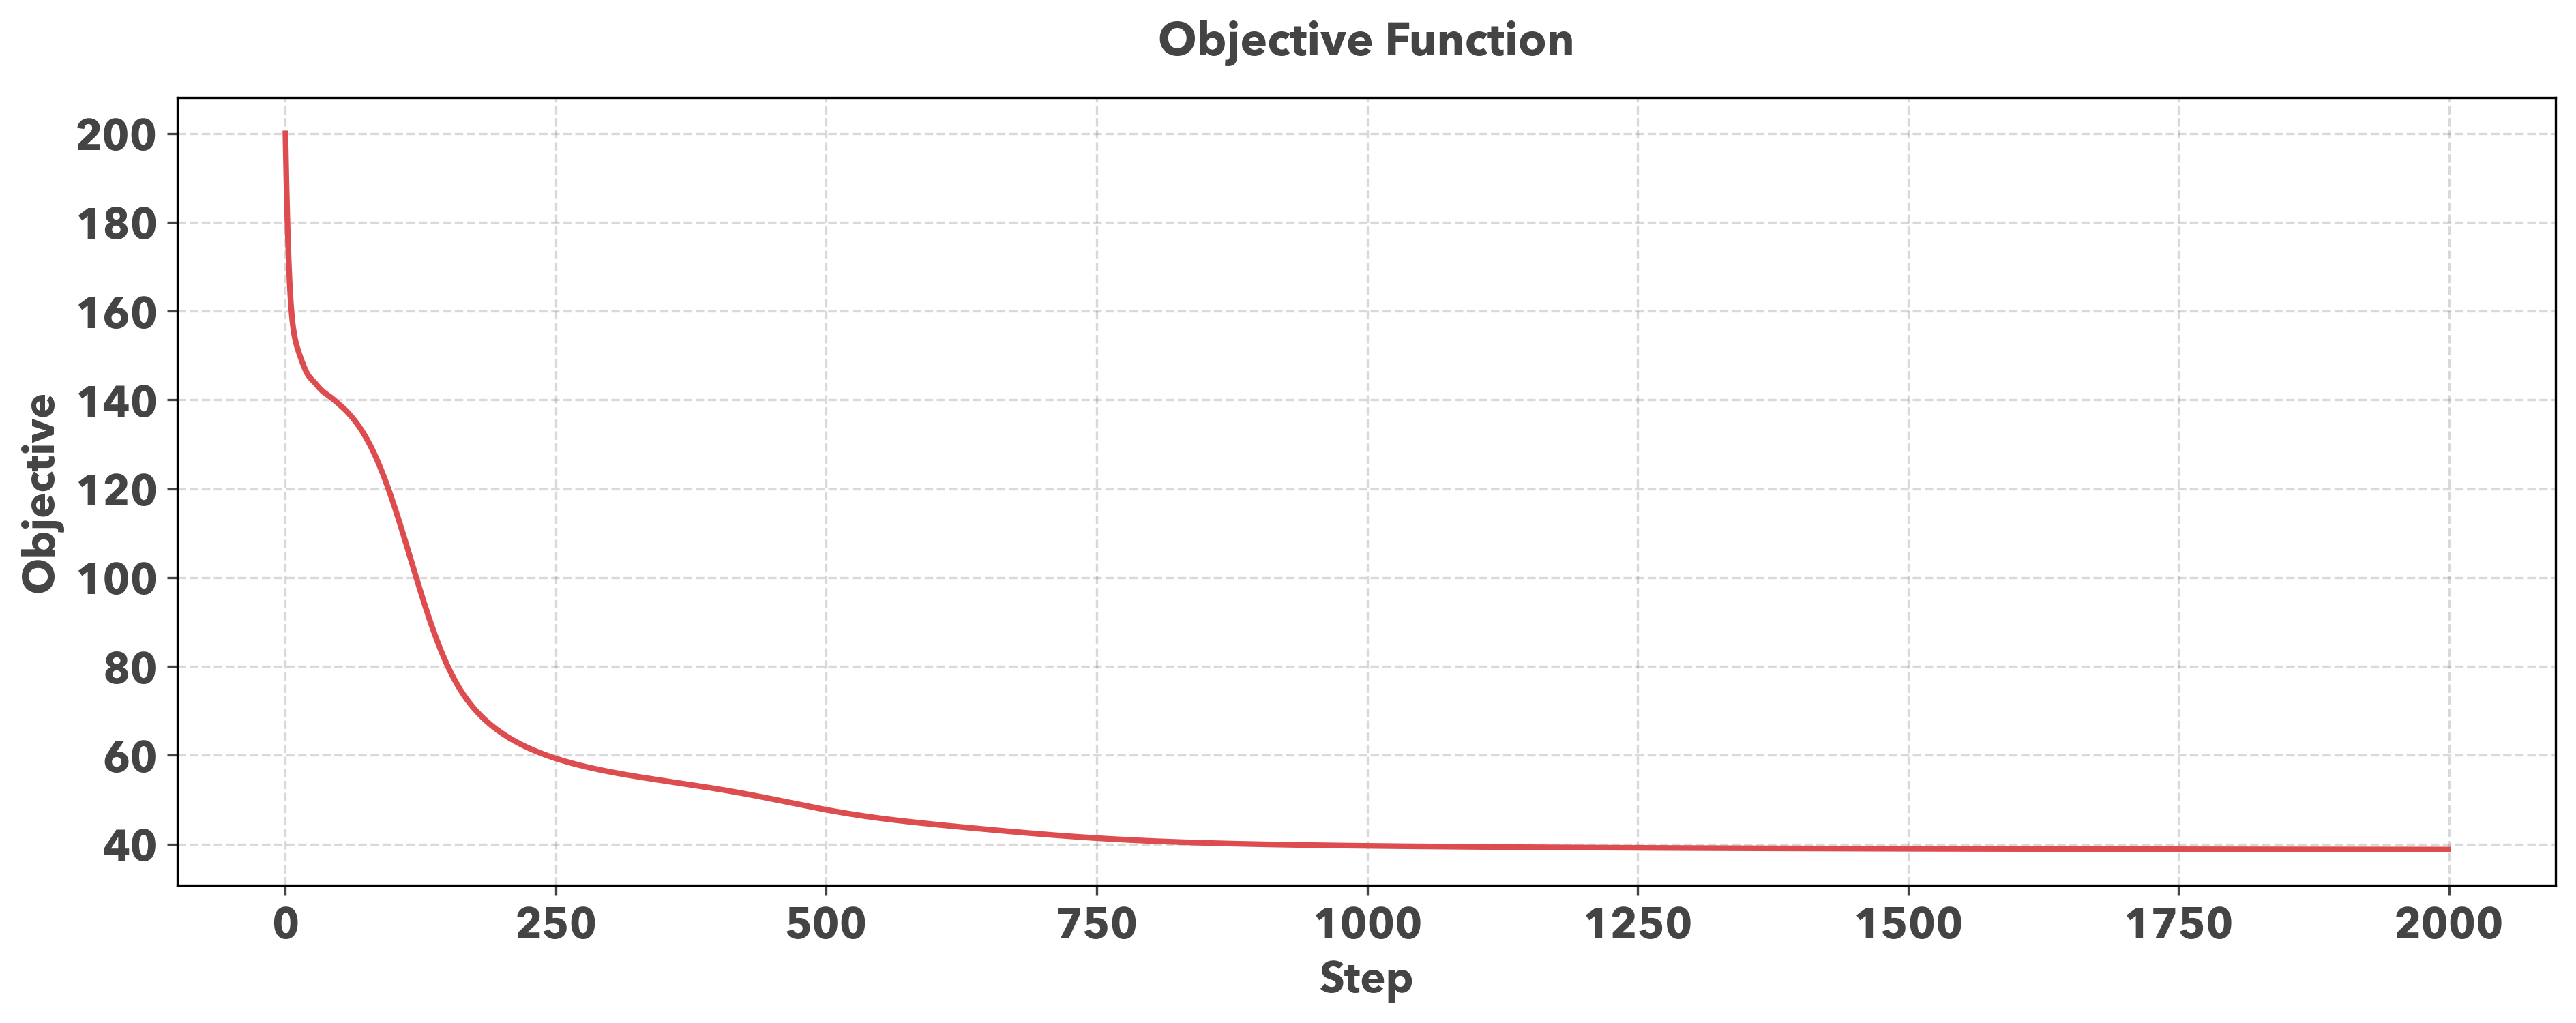

In [7]:
plt.rcParams['font.family'] = 'Avenir Next'
plt.rcParams['font.weight'] = 200
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titleweight'] = 200
plt.rcParams['axes.labelweight'] = 200
plt.rcParams['figure.dpi'] = 300
curve_color = '#DD4C4F'

plt.figure(figsize=(15, 5), facecolor='#ffffff')

plt.plot(objective, color=curve_color, linewidth=2)
plt.title('Objective Function', pad=15, color='#444444')
plt.xlabel('Step', color='#444444')
plt.ylabel('Objective', color='#444444')
plt.grid(True, alpha=0.2, color='#444444', linestyle='--')
plt.tick_params(colors='#444444')

## Approach 2 - Iteration till convergence


In [8]:
def iterative_convergence(
    beta_hat: np.array,
    excess_returns: np.array,
    N: int,
    K: int,
    R: int, 
    T: int,
    rtol: float = 1e-05,
    atol: float = 1e-08,
    n_iter: int = 2000,
    seed: int = 0,
) -> tuple[np.array, np.array, np.array]:
    """
    Solves constrained optimization by iterating
    until convergence

    Args:
        beta_hat (np.array): estimated beta loadings, N * K * T
        excess_returns (np.array): excess returns, N * T
        N (int): number of assets
        K (int): number of observed assets
        R (int): number of unobserved factors
        T (int): number of time periods
        rtol (float): relative tolerance for convergence, refer to
            numpy.allclose documentation
        atol (float): absolute tolerance for convgernce
        n_iter (int): number of iterations
        seed (int): for reproducibility

    Returns:
        tuple[np.array, np.array, np.array, np.array]:
            eta: N * (1 + K)
            G: T * R
            beta^*: N * R
            objective: n_iter
    """

    assert beta_hat.ndim == 3, f"beta_hat must be 3D, got {beta_hat.ndim}"
    assert beta_hat.shape == (N, K, T), f"beta_hat.shape {beta_hat.shape} != ({N}, {K}, {T})"
    assert excess_returns.ndim == 2, f"excess_returns must be 2D, got {excess_returns.ndim}"
    assert excess_returns.shape == (N, T), f"excess_returns.shape {excess_returns.shape} != ({N}, {T})"

    np.random.seed(seed)

    beta_hat_t = beta_hat.transpose(0, 2, 1)  #(N, T, K)
    r = excess_returns                      #(N, T)
    ones = np.ones((N, T, 1))
    X = np.concatenate([ones, beta_hat_t], axis=2) # (N, T, 1 + K)

    eta = np.random.normal(0, 0.1, size = (N, 1 + K))
    beta_star = np.random.normal(0, 0.1, size = (N, R))
    G = np.random.normal(0, 0.1, size = (T, R))

    objective = np.empty(shape=(n_iter))

    for i in range(N):
        Xi = X[i]              # (T, 1+K)
        ri = r[i]              # (T,)

        # (X'X)^{-1} X'r
        A = Xi.T @ Xi          # (1+K, 1+K)
        b = Xi.T @ ri          # (1+K,)

        A = A + 1e-8 * np.eye(1 + K)
        eta[i] = np.linalg.solve(A, b)

    # U_i = r_i - X_i η_i
    U = np.zeros((T, N))
    for i in range(N):
        Xi = X[i]               # (T, 1+K)
        ri = r[i]               # (T,)
        ui = ri - Xi @ eta[i]   # (T,)
        U[:, i] = ui

    # (1/NT) \sum_{i=1}^{N} (r_i - X eta) (r - X eta)'
    S = (U @ U.T) / (N * T)      # (T, T)
    eigvals, eigvecs = np.linalg.eigh(S)
    G = eigvecs[:, -R:] * np.sqrt(T)            # (T, R)
    I_T = np.eye(T)

    for it in range(n_iter):
        G_old = G.copy()

        # M_G = I - G(G'G)^{-1}G'
        GtG = G.T @ G                    # (R, R)
        GtG_inv = np.linalg.inv(GtG)  # (R, R)
        Proj_G = G @ GtG_inv @ G.T       # (T, T)
        M_G = I_T - Proj_G

        # update eta and beta_star given G
        for i in range(N):
            Xi = X[i]                # (T, 1+K)
            ri = r[i]                # (T,)

            # eta = (X' M_G X)^{-1} X' M_G r
            A = Xi.T @ M_G @ Xi      # (1+K, 1+K)
            b = Xi.T @ M_G @ ri      # (1+K,)

            A = A + 1e-8 * np.eye(1 + K)
            eta[i] = np.linalg.solve(A, b)

            # calculate new residuals and beta_star
            vi = ri - Xi @ eta[i]              # (T,)
            beta_star[i] = GtG_inv @ (G.T @ vi)  # (R,)

        # update G
        U = np.zeros((T, N))
        for i in range(N):
            Xi = X[i]                  # (T, 1+K)
            ri = r[i]                  # (T,)
            ui = ri - Xi @ eta[i]
            U[:, i] = ui

        S = (U @ U.T) / (N * T)
        eigvals, eigvecs = np.linalg.eigh(S)
        G = eigvecs[:, -R:] * np.sqrt(T)

        # objective value
        U = np.zeros((T, N))
        for i in range(N):
            Xi = X[i]
            ri = r[i]
            U[:, i] = ri - Xi @ eta[i]  

        # term_i[t] = u_i[t] - G[t] @ beta_star[i]
        loss_matrix = np.zeros((T, N))
        for i in range(N):
            loss_matrix[:, i] = U[:, i] - G @ beta_star[i]

        obj_value = np.mean(loss_matrix ** 2)

        objective[it] = obj_value.item()

        if (it + 1) % 100 == 0:
            loss = np.linalg.norm(G - G_old, ord="fro")
            log_str = (
                f"Iter {it + 1}/{n_iter}, "
                f"frobenius_norm(G - G_old)={loss:.4f}, "
                f"objective={obj_value:.6f}"
            )
            print(log_str)

        if np.allclose(G, G_old, rtol=rtol, atol=atol):
            print(f"Converged at iteration {it+1}")
            break

    return eta, G, beta_star, objective


In [9]:
eta2, G2, bstar2, objective2 = iterative_convergence(
    beta_hat_np, 
    excess_returns,
    N = 47,
    K = 5, 
    R = 3,
    T = 206,
    n_iter=200
)

Iter 100/200, frobenius_norm(G - G_old)=0.0251, objective=38.656692
Iter 200/200, frobenius_norm(G - G_old)=0.0121, objective=38.647078


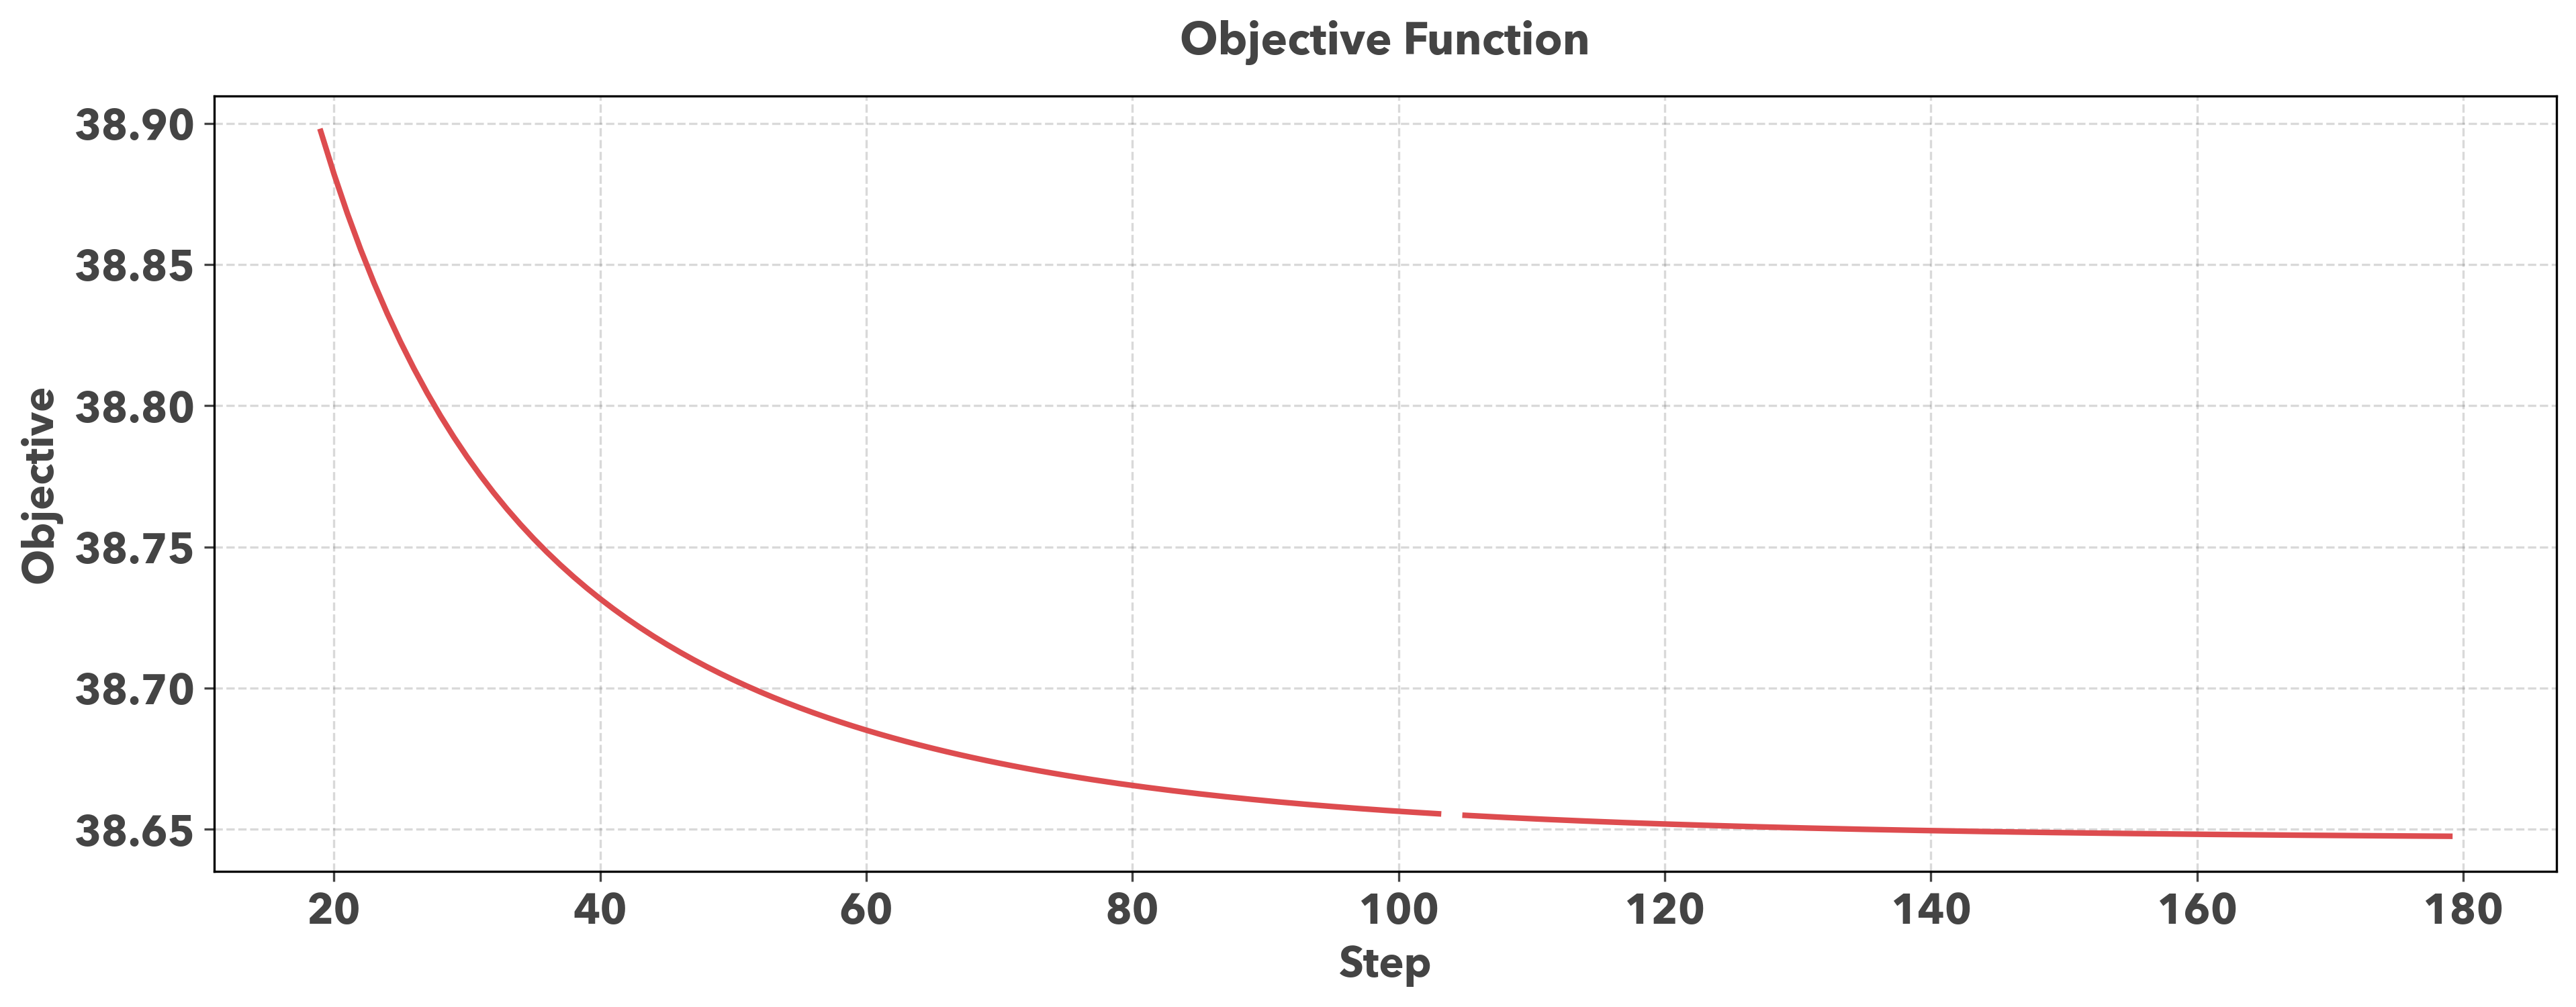

In [10]:
plt.rcParams['font.family'] = 'Avenir Next'
plt.rcParams['font.weight'] = 200
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titleweight'] = 200
plt.rcParams['axes.labelweight'] = 200
plt.rcParams['figure.dpi'] = 300
curve_color = '#DD4C4F'

plt.figure(figsize=(15, 5), facecolor='#ffffff')

plt.plot(
    np.where(
        (objective2 < np.nanpercentile(objective2, 10)) |
        (objective2 > np.nanpercentile(objective2, 90)),
        np.nan,
        objective2
    ),
    color=curve_color,
    linewidth=2
)
plt.title('Objective Function', pad=15, color='#444444')
plt.xlabel('Step', color='#444444')
plt.ylabel('Objective', color='#444444')
plt.grid(True, alpha=0.2, color='#444444', linestyle='--')
plt.tick_params(colors='#444444')

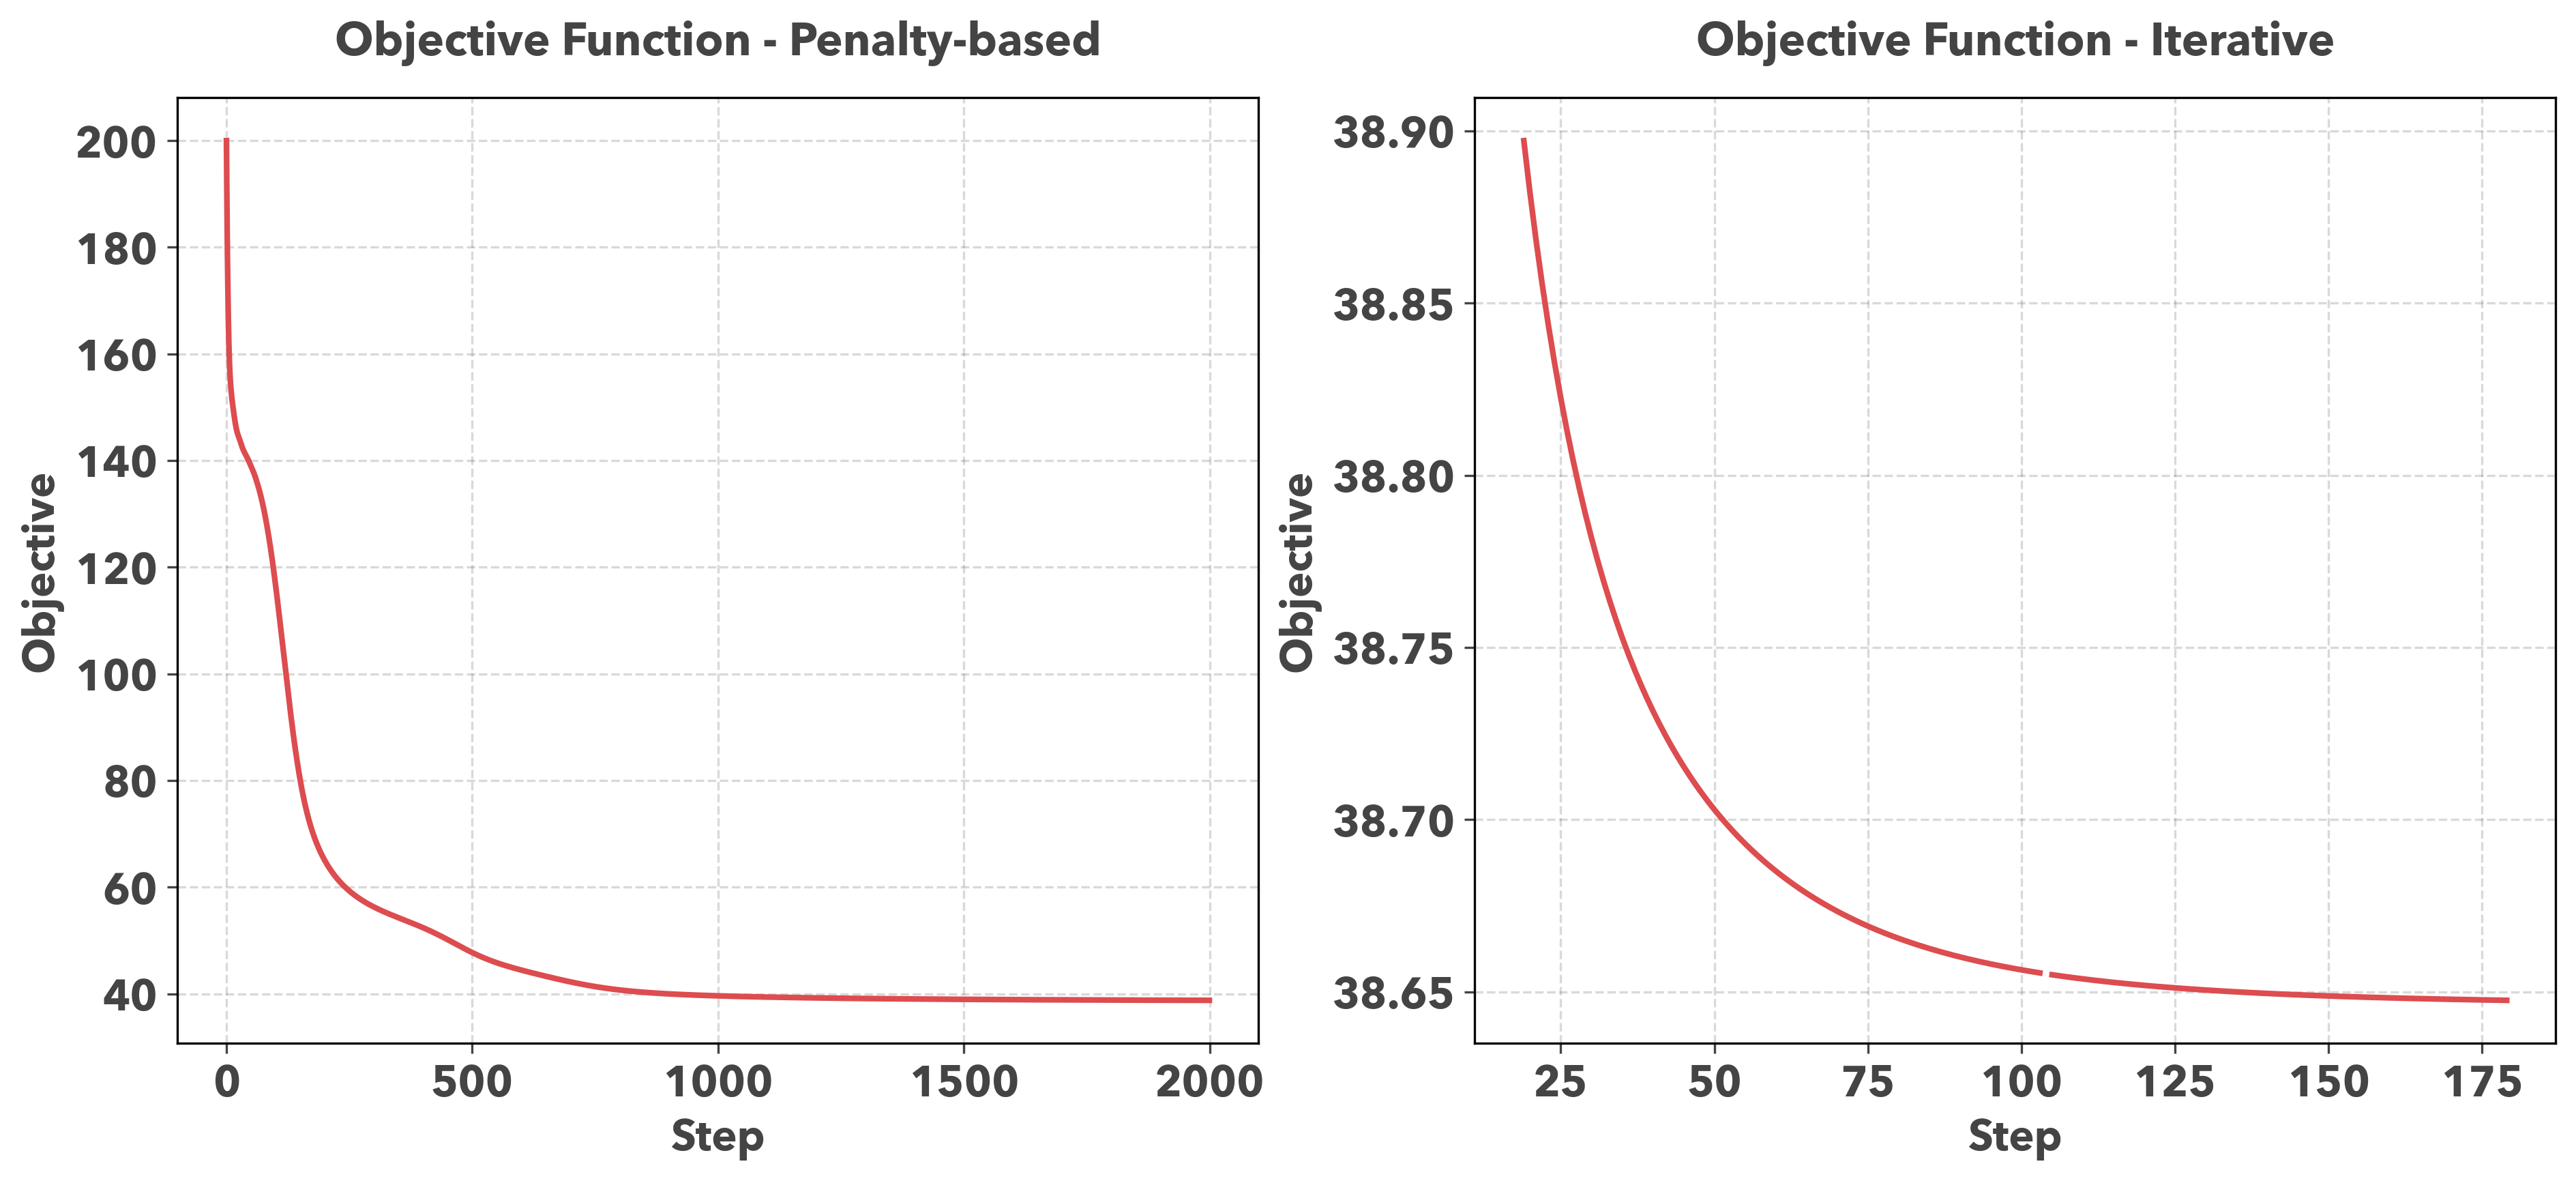

In [39]:
plt.rcParams['font.family'] = 'Avenir Next'
plt.rcParams['font.weight'] = 200
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titleweight'] = 200
plt.rcParams['axes.labelweight'] = 200
plt.rcParams['figure.dpi'] = 300
curve_color = '#DD4C4F'

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes = np.ravel(axes)


axes[0].plot(objective, color=curve_color, linewidth=2)
axes[0].set_title('Objective Function - Penalty-based', pad=15, color='#444444')
axes[0].set_xlabel('Step', color='#444444')
axes[0].set_ylabel('Objective', color='#444444')
axes[0].grid(True, alpha=0.2, color='#444444', linestyle='--')
axes[0].tick_params(colors='#444444')


axes[1].plot(
    np.where(
        (objective2 < np.nanpercentile(objective2, 10)) |
        (objective2 > np.nanpercentile(objective2, 90)),
        np.nan,
        objective2
    ),
    color=curve_color,
    linewidth=2
)
axes[1].set_title('Objective Function - Iterative', pad=15, color='#444444')
axes[1].set_xlabel('Step', color='#444444')
axes[1].set_ylabel('Objective', color='#444444')
axes[1].grid(True, alpha=0.2, color='#444444', linestyle='--')
axes[1].tick_params(colors='#444444')

## Validation of estimate

In [17]:
def simulate_dgp(
    N, K, R, T,
    heterogeneity_strength=0.0,
    sigma_u=0.2,
    sigma_eps=0.5,
    sigma_g=1.0,
    seed=None
):
    """
    Simulates data consistent with the Galvao et al. model structure.
    Returns:
        beta_true      : (N, K, T)
        r              : (N, T)
        realized_cov   : (N, K, T)
        residuals      : (N, K, T)
        G_true         : (T, R)
        beta_star_true : (N, R)
        lambda_true    : (N, K)
    """
    rng = np.random.default_rng(seed)

    G_true = rng.normal(0, sigma_g, size=(T, R))
    
    lambda_true = np.zeros((N, K))
    for i in range(N):
        lambda_true[i] = heterogeneity_strength * rng.normal(0, 1, size=K)

    beta_star_true = rng.normal(0, 1, size=(N, R))

    beta_true = np.zeros((N, K, T))
    for i in range(N):
        beta_i0 = rng.normal(0, 1, size=K)
        for t in range(T):
            beta_true[i, :, t] = beta_i0 + sigma_u * rng.normal(0, 1, size=K)

    realized_cov = beta_true + sigma_u * rng.normal(0, 1, size=(N, K, T))
    residuals = sigma_u * rng.normal(0, 1, size=(N, K, T))

    r = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            r[i, t] = (
                lambda_true[i] @ beta_true[i, :, t]
                + beta_star_true[i] @ G_true[t]
                + sigma_eps * rng.normal()
            )

    return beta_true, r, realized_cov, residuals, G_true, beta_star_true, lambda_true


In [ ]:
def build_true_eta(lambda_true):
    """
    lambda_true: (N, K)
    returns eta_true: (N, K+1)
    """
    N, K = lambda_true.shape
    eta_true = np.zeros((N, K+1))
    eta_true[:, 1:] = lambda_true
    return eta_true

def mc_compare_estimators(
    N=10, K=3, R=1, T=200,
    n_rep=50,
    heterogeneity_strength=0.5,
    seed=123,
    verbose=False
):
    rng = np.random.default_rng(seed)

    eta_diff = []
    rmse_pen_list = []
    rmse_iter_list = []
    obj_pen_final = []
    obj_iter_final = []
    obj_pen_all = []
    obj_iter_all = []

    for rep in range(n_rep):
        rep_seed = rng.integers(1_000_000_000)

        (
            beta_true,
            r,
            realized_cov,
            residuals,
            G_true,
            beta_star_true,
            lambda_true
        ) = simulate_dgp(
            N=N, K=K, R=R, T=T,
            heterogeneity_strength=heterogeneity_strength,
            seed=rep_seed
        )

        eta_true = build_true_eta(lambda_true)
        beta_hat = beta_true

        eta_pen, G_pen, beta_star_pen, obj_pen = penalty_based_minimization(
            beta_hat, r, N, K, R, T,
            lam=1.0, lr=1e-2, n_iter=1000, seed=rep_seed
        )
        obj_pen_all.append(obj_pen)

        eta_iter, G_iter, beta_star_iter, obj_iter = iterative_convergence(
            beta_hat, r, N, K, R, T,
            n_iter=1000, seed=rep_seed
        )
        obj_iter_all.append(obj_iter)

        diff = np.linalg.norm(eta_pen - eta_iter) / np.sqrt(N*(K+1))
        eta_diff.append(diff)

        rmse_pen = np.linalg.norm(eta_pen - eta_true) / np.sqrt(N*(K+1))
        rmse_iter = np.linalg.norm(eta_iter - eta_true) / np.sqrt(N*(K+1))

        rmse_pen_list.append(rmse_pen)
        rmse_iter_list.append(rmse_iter)

        obj_pen_final.append(obj_pen[-1])
        obj_iter_final.append(obj_iter[-1])

        if verbose:
            print(
                f"[{rep+1}/{n_rep}] diff={diff:.4f}, "
                f"RMSE_pen={rmse_pen:.4f}, RMSE_iter={rmse_iter:.4f}"
            )

    obj_pen_all = np.vstack(obj_pen_all)
    obj_iter_all = np.vstack(obj_iter_all)

    return {
        "eta_diff": np.array(eta_diff),
        "rmse_pen": np.array(rmse_pen_list),
        "rmse_iter": np.array(rmse_iter_list),
        "obj_pen_final": np.array(obj_pen_final),
        "obj_iter_final": np.array(obj_iter_final),
        "obj_pen_all": obj_pen_all,
        "obj_iter_all": obj_iter_all,
    }

In [43]:
def summarize_mc_results(results):
    print("Mean ||η_pen - η_iter||:", results["eta_diff"].mean())
    print("Std  ||η_pen - η_iter||:", results["eta_diff"].std())

    print("\nRMSE vs true η:")
    print("Penalty estimator mean RMSE:", results["rmse_pen"].mean())
    print("Iterative estimator mean RMSE:", results["rmse_iter"].mean())

    plt.hist(results["eta_diff"], bins=20)
    plt.title("Distribution of ||η_pen − η_iter||")
    plt.show()

    plt.hist(results["rmse_pen"], alpha=0.6, bins=20, label="Penalty")
    plt.hist(results["rmse_iter"], alpha=0.6, bins=20, label="Iterative")
    plt.legend()
    plt.title("RMSE(η̂ vs η_true)")
    plt.show()


In [ ]:
results = mc_compare_estimators(
    N=10, K=3, R=1, T=200,
    n_rep=1000,
    heterogeneity_strength=0.5,
    verbose=True
)

Mean ||η_pen - η_iter||: 0.13549610740681772
Std  ||η_pen - η_iter||: 0.06303714782188485

RMSE vs true η:
Penalty estimator mean RMSE: 0.21490165579445744
Iterative estimator mean RMSE: 0.23338957450207307


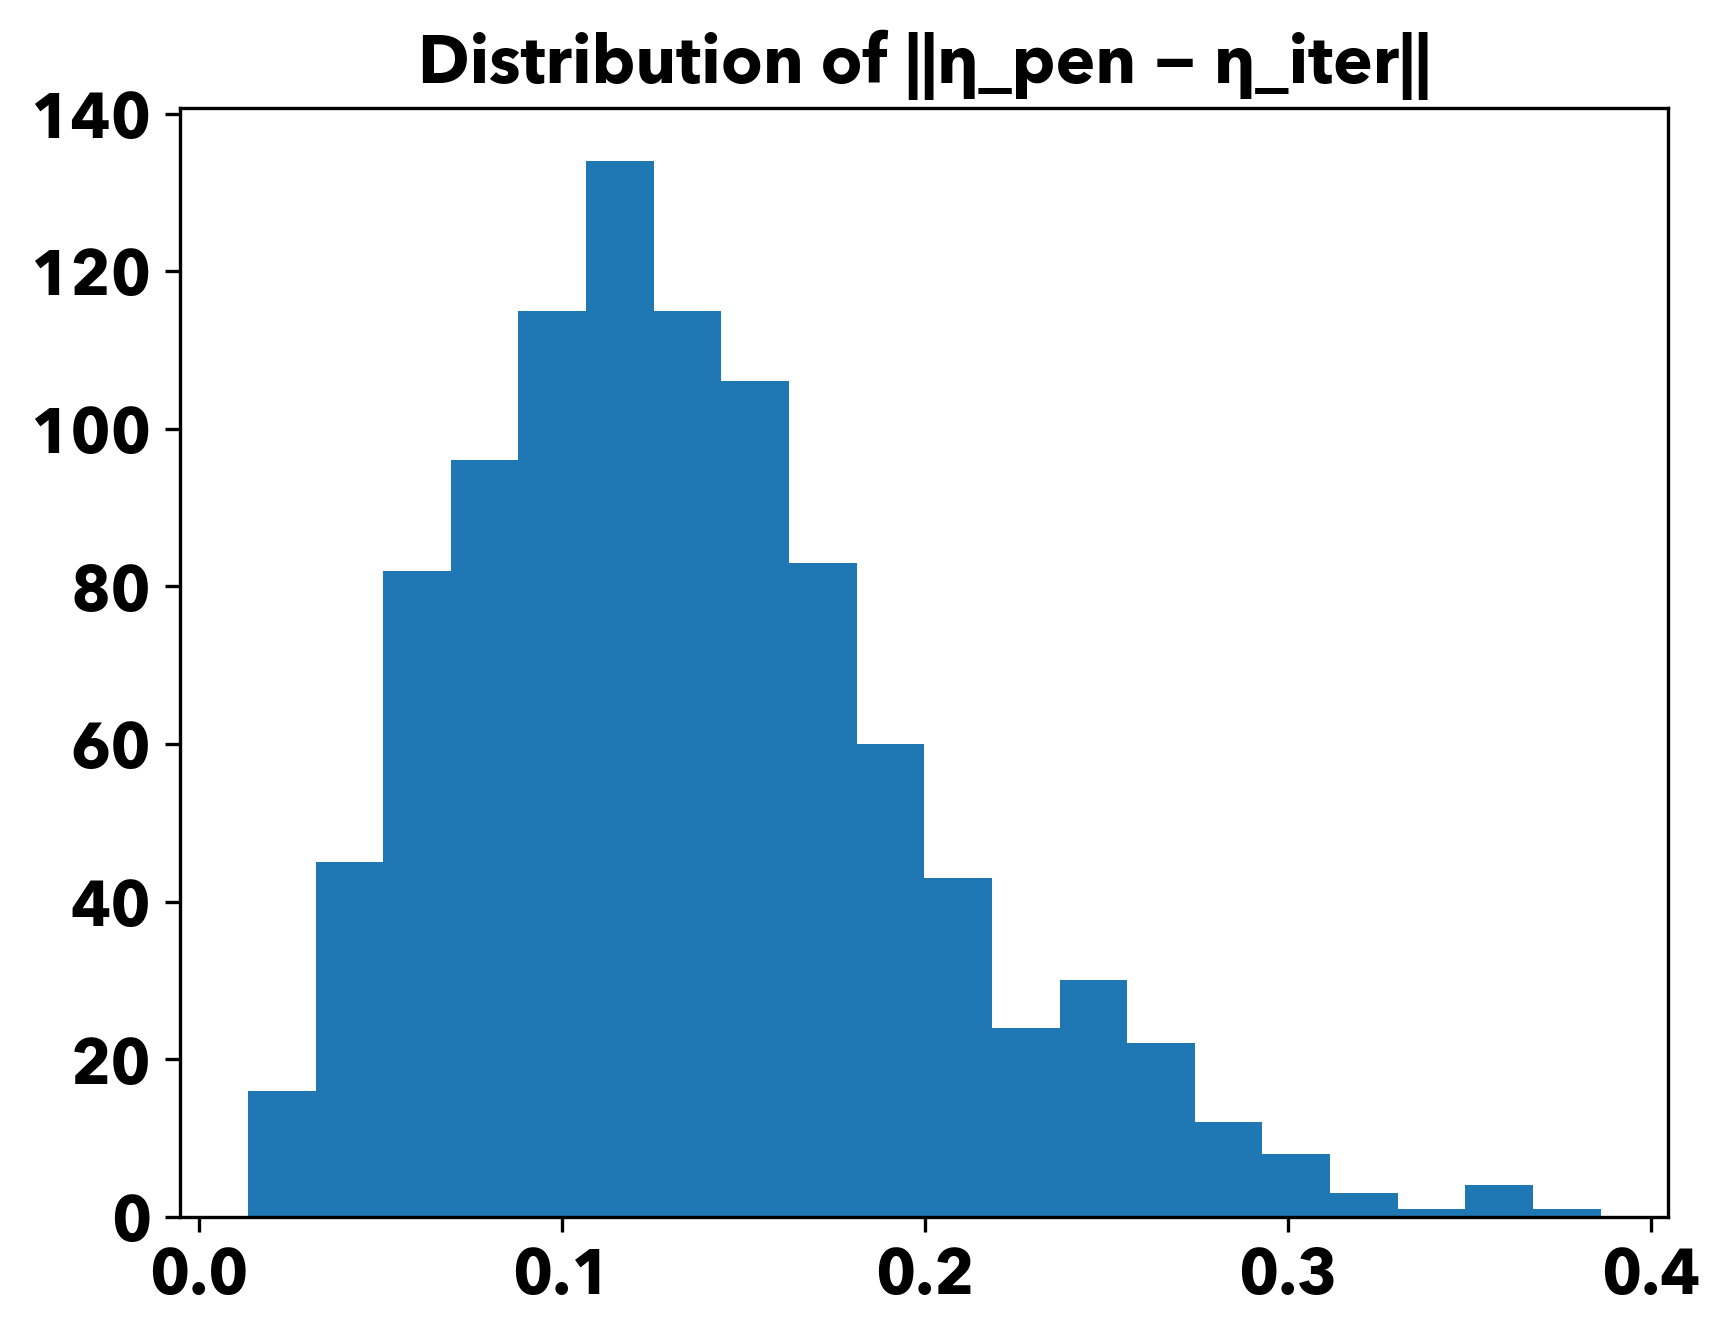

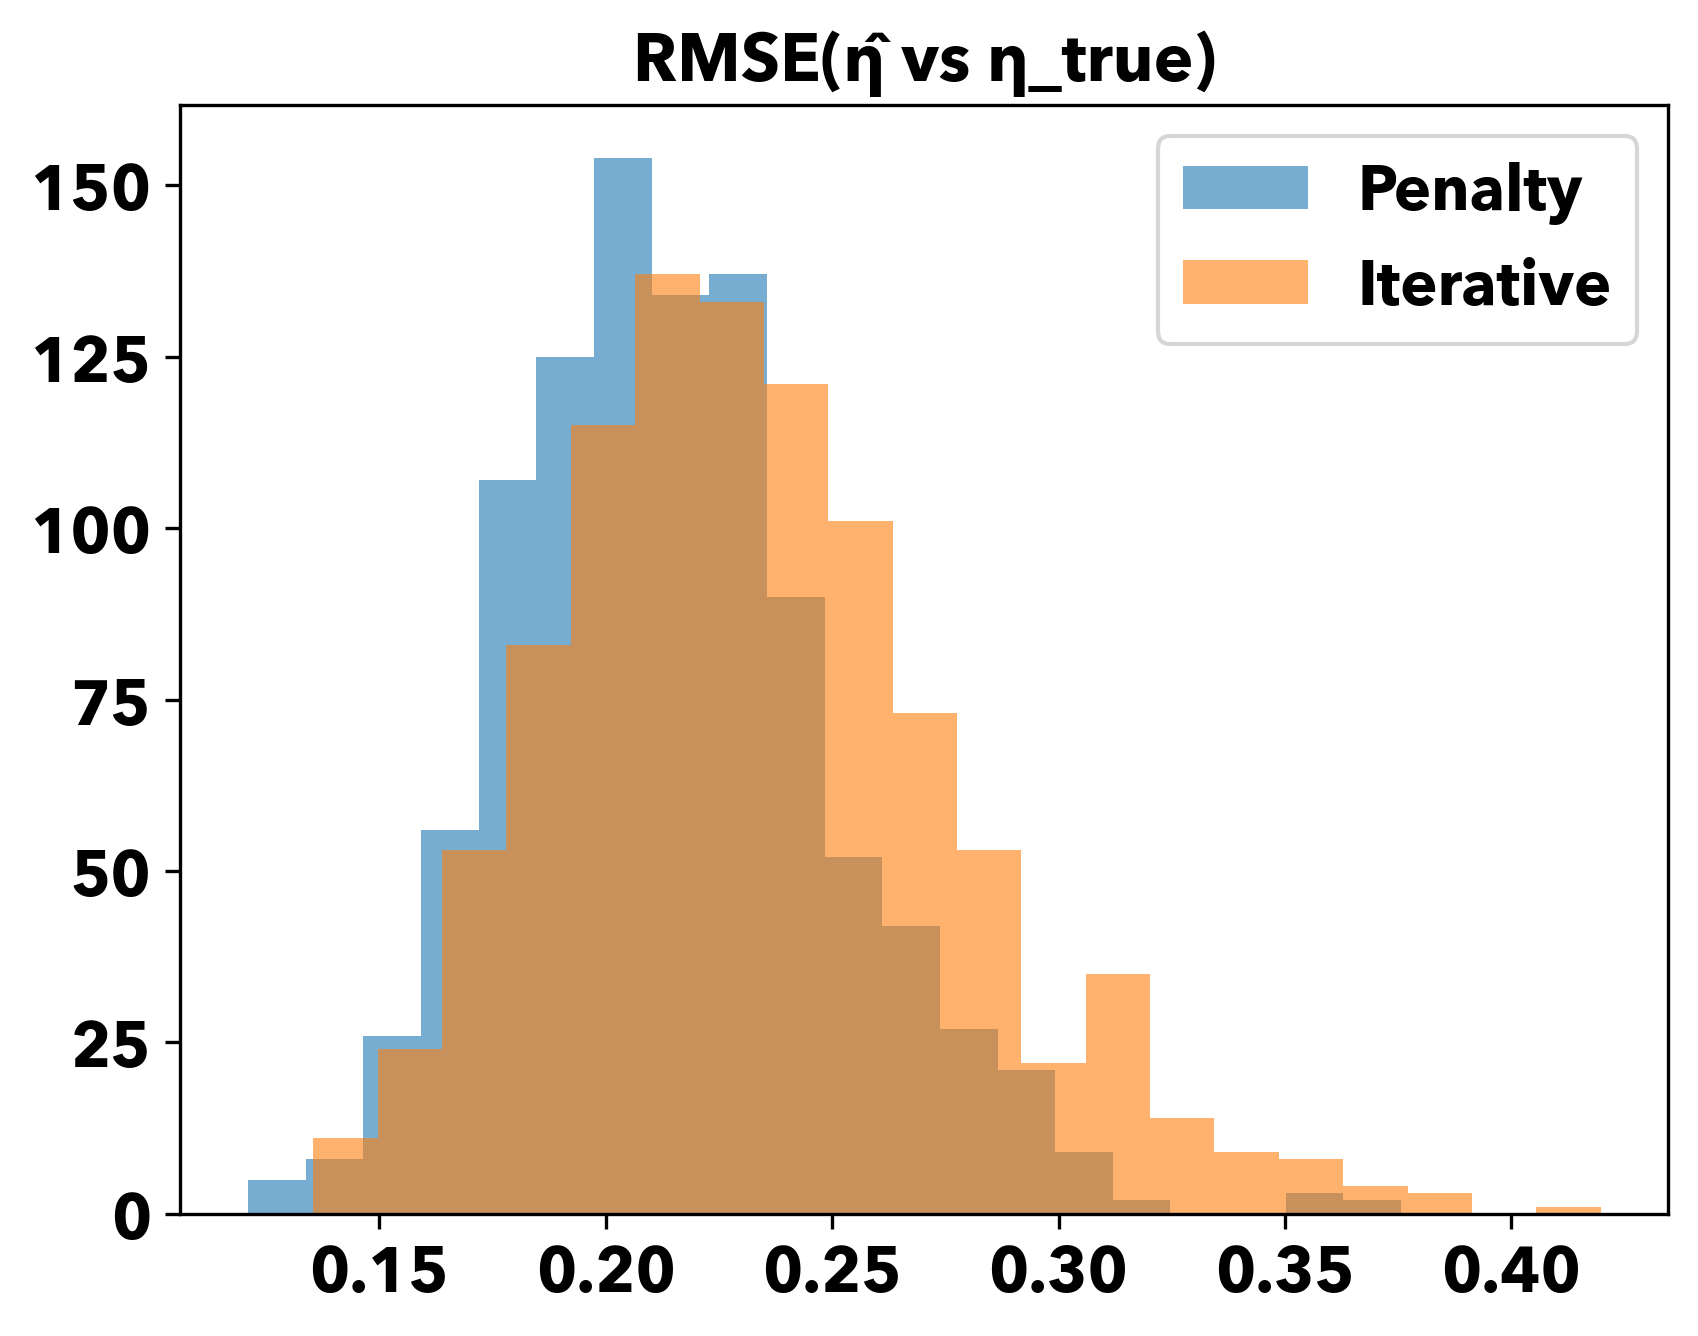

In [46]:
summarize_mc_results(results)

In [47]:
mean_diff = results["eta_diff"].mean()
std_diff = results["eta_diff"].std()

rmse_pen = results["rmse_pen"].mean()
rmse_iter = results["rmse_iter"].mean()

summary_df = pd.DataFrame({
    "Metric": [
        "Mean ||η_pen − η_iter||",
        "Std  ||η_pen − η_iter||",
        "RMSE (Penalty Estimator)",
        "RMSE (Iterative Estimator)"
    ],
    "Value": [
        mean_diff,
        std_diff,
        rmse_pen,
        rmse_iter
    ]
})

summary_df

,Metric,Value
0,Mean ||η_pen − η_iter||,0.135496
1,Std ||η_pen − η_iter||,0.063037
2,RMSE (Penalty Estimator),0.214902
3,RMSE (Iterative Estimator),0.233390


In [ ]:
latex_table = summary_df.round(3).to_latex(
    index=False,
    float_format="%.3f",
    caption="Monte Carlo Comparison of Penalty-Based and Iterative Estimators",
    label="tab:mc_eta_comparison",
    escape=False
)

print(latex_table)